### Task 4 : Image Reconstruction using Matrix Factorisation 

### 1. Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank r. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics. [1 Marks]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Generic Matrix Factorization (without missing values)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Randomly initialize A and B

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def factorize1(A, k, device=torch.device("cpu")):
    """Factorize the matrix A into W and H  
    A: input matrix of size (n_pixels,)
    k: number of latent features
    
    Returns W and H
    W: matrix of size (n_pixels, k)
    H: matrix of size (k, 1)
    """
    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, 1, requires_grad=True, device=device)
    
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    
    # Train the model
    for i in range(1000):
        # Compute the loss (Frobenius norm)
        reconstructed = torch.mm(W, H)
        loss = torch.norm(reconstructed - A.unsqueeze(1))
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
    
    return W, H, loss


In [5]:
# Updated factorize function with convergence
def factorize(A, k, device=torch.device("cpu"), lr=0.01, max_iters=10000, tol=1e-4):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=lr)
    
    prev_loss = float('inf')
    
    for i in range(max_iters):
        loss = torch.norm(torch.mm(W, H) - A)
        if abs(prev_loss - loss.item()) < tol:
            # print(f'Converged after {i} iterations.')
            break
        prev_loss = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return W, H, loss


Factorize1 is the function used by sir which uses 1000 iterations, here intuitively we think gradient descent converges after 1000 iterations but in the second factorize function we define a tolerance tol=1e-4 which is generally used in adam kind of functions as a loss below which the loss is considered as overfitting. By checking the evaluation metrics at the end we can understand it at the end.

In [6]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [7]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


In [8]:
# Make grayscale
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([1365, 2048])


In [9]:
img.shape

torch.Size([1365, 2048])

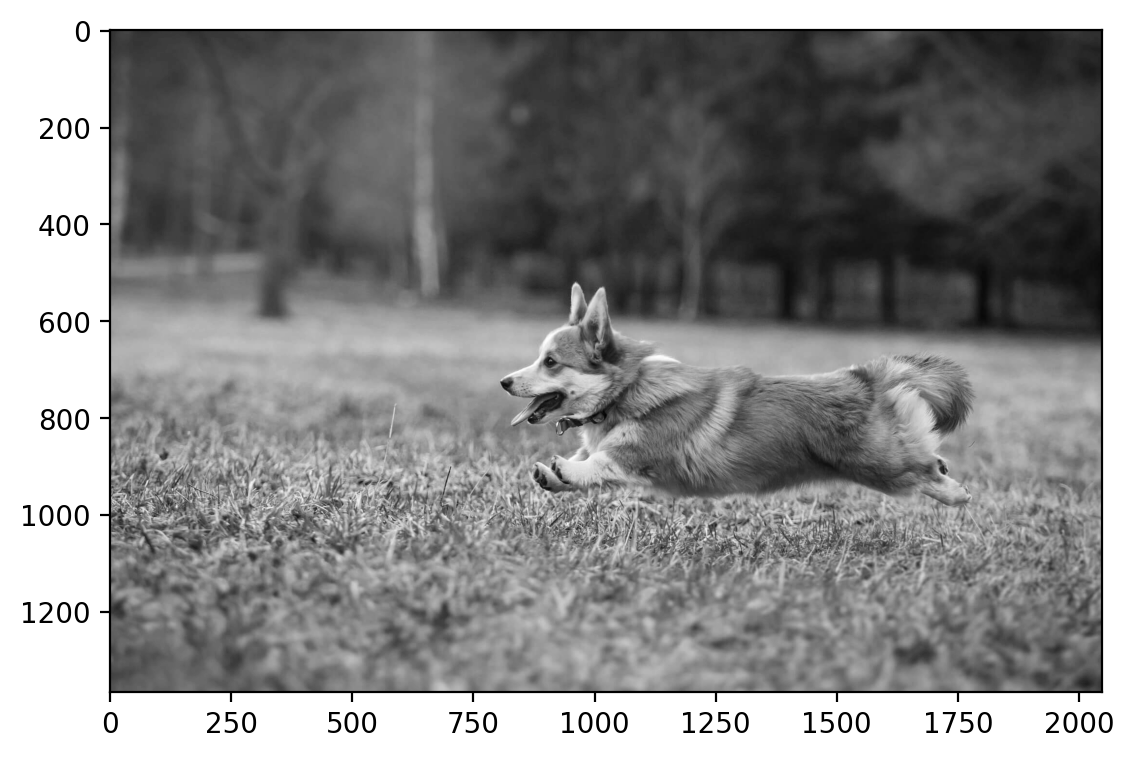

In [10]:
plt.imshow(img, cmap='gray')

In [11]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
crop.shape

torch.Size([300, 300])

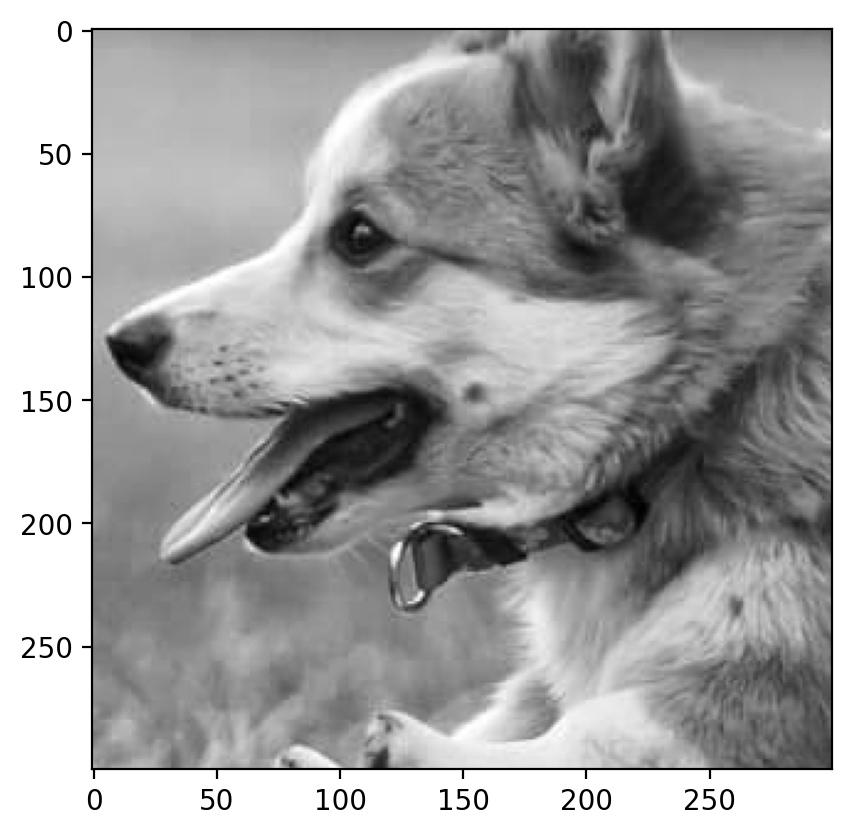

In [12]:
plt.imshow(crop, cmap='gray')


In [13]:
# Function to compute RMSE
def compute_rmse(original, reconstructed):
    return torch.sqrt(torch.mean((original - reconstructed) ** 2)).item()

# Function to compute PSNR
def compute_psnr(original, reconstructed):
    original_np = original.numpy()
    reconstructed_np = reconstructed.numpy()
    mse = np.mean((original_np - reconstructed_np) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

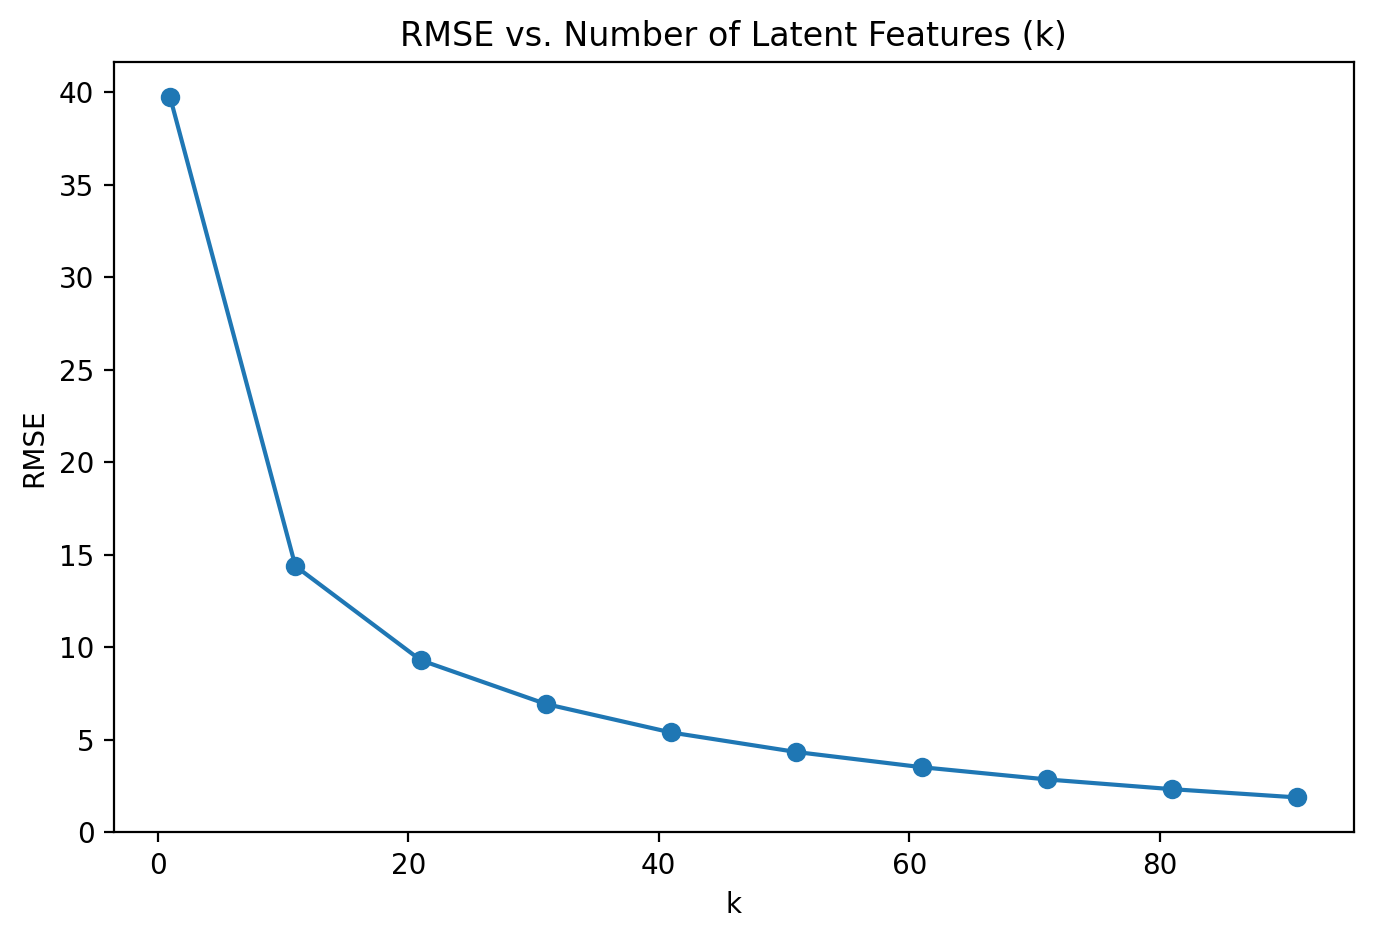

In [14]:
def find_optimal_k(min_k, max_k, step=10):
    """Finds the optimal value of k using RMSE."""
    rmse_values = []
    k_values = range(min_k, max_k, step)
    
    for k in k_values:
        W, H, loss = factorize(crop, k, device=device)
        reconstructed_img = torch.mm(W, H).detach()
        rmse = compute_rmse(crop, reconstructed_img)
        rmse_values.append(rmse)
    
    # Plot RMSE against different k values
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, rmse_values, marker='o')
    plt.title('RMSE vs. Number of Latent Features (k)')
    plt.xlabel('k')
    plt.ylabel('RMSE')
    plt.show()

# Run to find optimal k
find_optimal_k(min_k=1, max_k=100)
#Value of optimal k is when the below loss flattens but it more computation to be done while training so better to use loss criteria

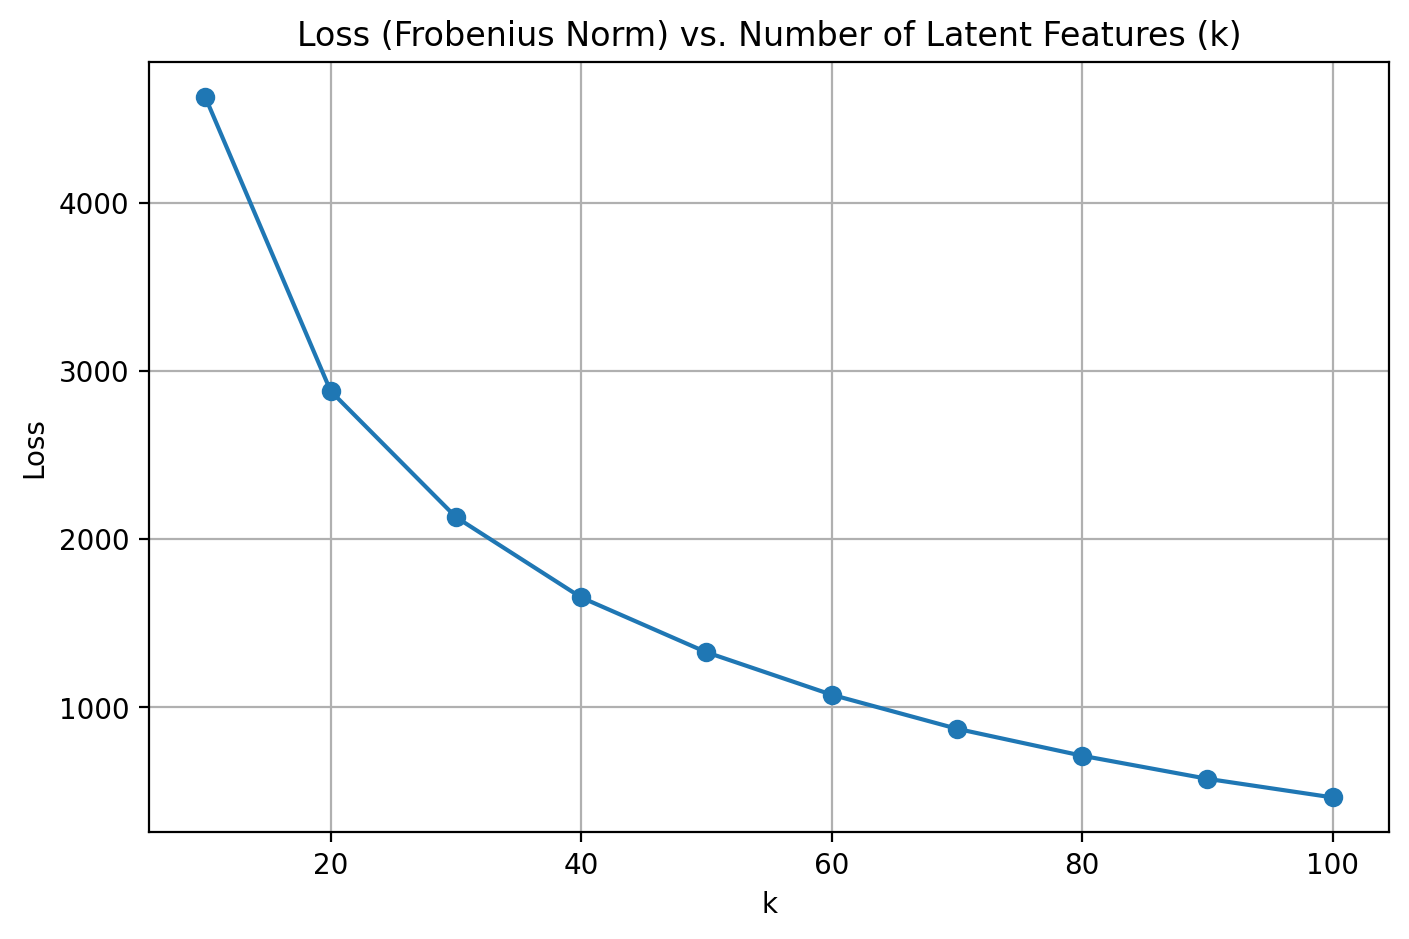

In [15]:
def check_reconstruction_for_k_values(A, device=torch.device("cpu")):
    """Check the reconstruction error for different values of k."""
    """Plot the loss (Frobenius norm) for different values of k."""
    loss_values = []
    
    # Loop over the different k values
    for k in range(10, 101, 10):
        # Factorize with the current k value
        W, H, loss = factorize(A, k, device=device)
        
        # Append the loss for the current k to the list
        loss_values.append(loss.item())
    
    k_values = list(range(10, 101, 10))
    # Plot loss vs k
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, loss_values, marker='o')
    plt.title('Loss (Frobenius Norm) vs. Number of Latent Features (k)')
    plt.xlabel('k')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


# Run the plot function
check_reconstruction_for_k_values(crop, device=device)


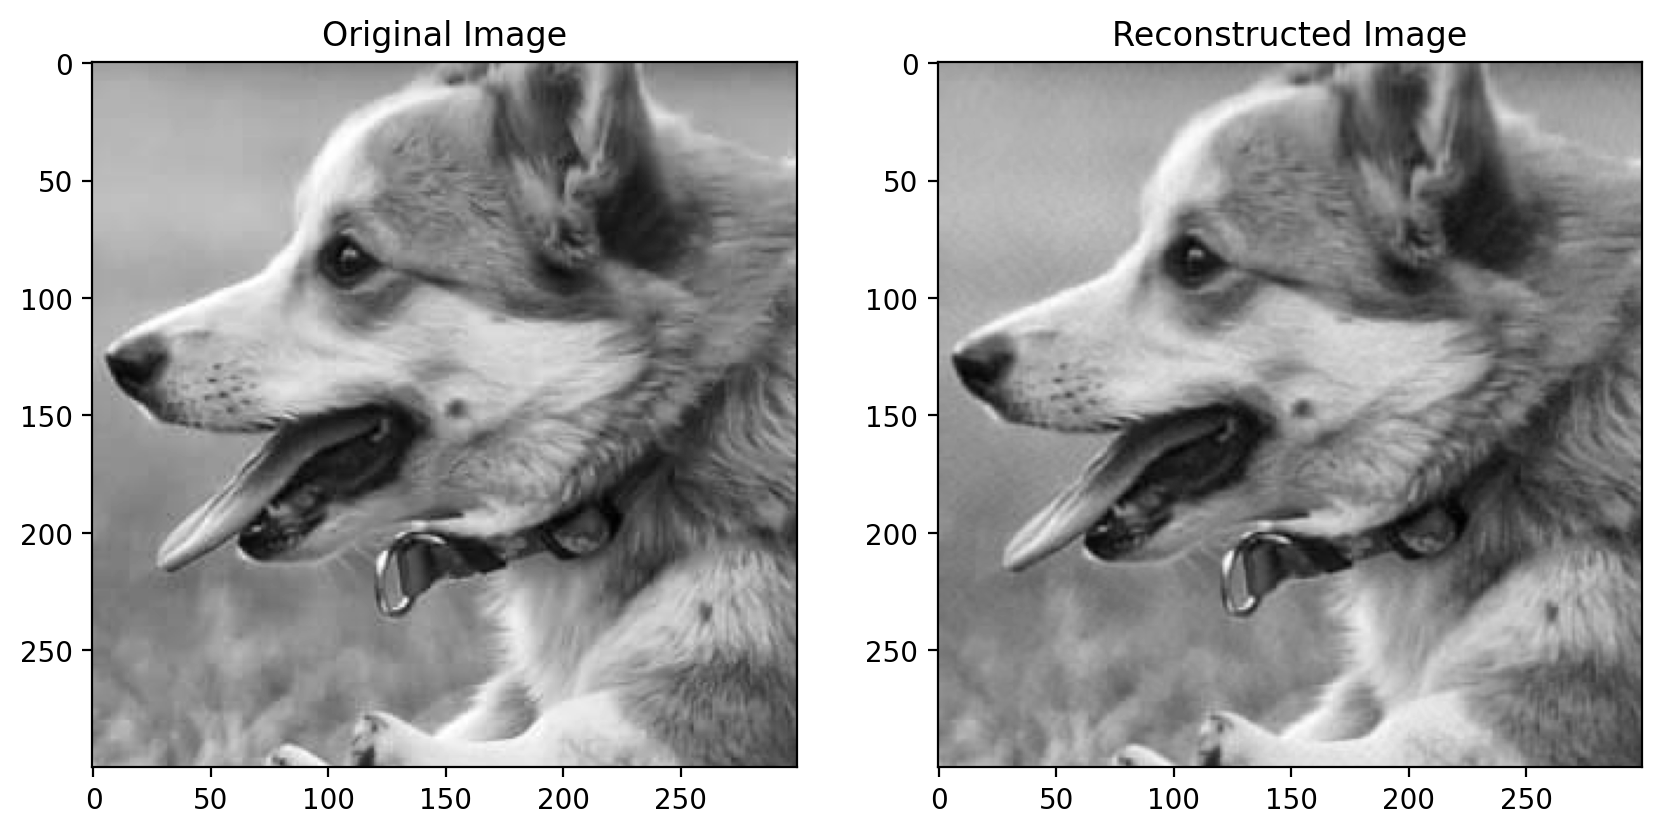

In [16]:
def plot_image_reconstruction(factors):
    """Reconstructs the original image using matrix factorization."""
    # Perform matrix factorization
    W, H, loss = factorize(crop, factors, device=device)
    
    # Create a figure to plot the original and reconstructed images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Reconstruct the image
    reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
    
    # Plot the original and reconstructed images
    ax[0].imshow(crop.cpu().detach().numpy(), cmap='gray')
    ax[0].set_title("Original Image")
    ax[1].imshow(reconstructed_img, cmap='gray')
    ax[1].set_title("Reconstructed Image")
    
    plt.show()

# Running the function
plot_image_reconstruction(factors=70)  # Try with different values of 'factors'


In [17]:
def evaluate_reconstruction(original_img, k, device=torch.device("cpu")):
    W, H, loss = factorize(original_img, k, device=device)
    
    # Reconstruct the image
    reconstructed_img = torch.mm(W, H).cpu().detach()

    # Compute RMSE and PSNR
    rmse = compute_rmse(original_img, reconstructed_img)
    psnr_value = compute_psnr(original_img, reconstructed_img)
    
    print(f'Final Loss: {loss.item()}')
    print(f'RMSE: {rmse}')
    print(f'PSNR: {psnr_value}')

# Assuming 'crop' is your image tensor and 'k' is your chosen rank
evaluate_reconstruction(crop, k=70, device=device)

Final Loss: 872.1647338867188
RMSE: 2.9072163105010986
PSNR: 38.861256678382084


In [18]:
def evaluate_reconstruction(original_img, k, device=torch.device("cpu")):
    W, H, loss = factorize1(original_img, k, device=device)
    
    # Reconstruct the image
    reconstructed_img = torch.mm(W, H).cpu().detach()

    # Compute RMSE and PSNR
    rmse = compute_rmse(original_img, reconstructed_img)
    psnr_value = compute_psnr(original_img, reconstructed_img)
    
    print(f'Final Loss: {loss.item()}')
    print(f'RMSE: {rmse}')
    print(f'PSNR: {psnr_value}')

# Assuming 'crop' is your image tensor and 'k' is your chosen rank
evaluate_reconstruction(crop, k=70, device=device)

Final Loss: 246010.546875
RMSE: 47.446598052978516
PSNR: 14.606701335779185


Original image shape: torch.Size([3, 1365, 2048])
Cropped image shape: torch.Size([3, 300, 300])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average RMSE: 0.027629165599743526
Average PSNR: 31.172720339692262


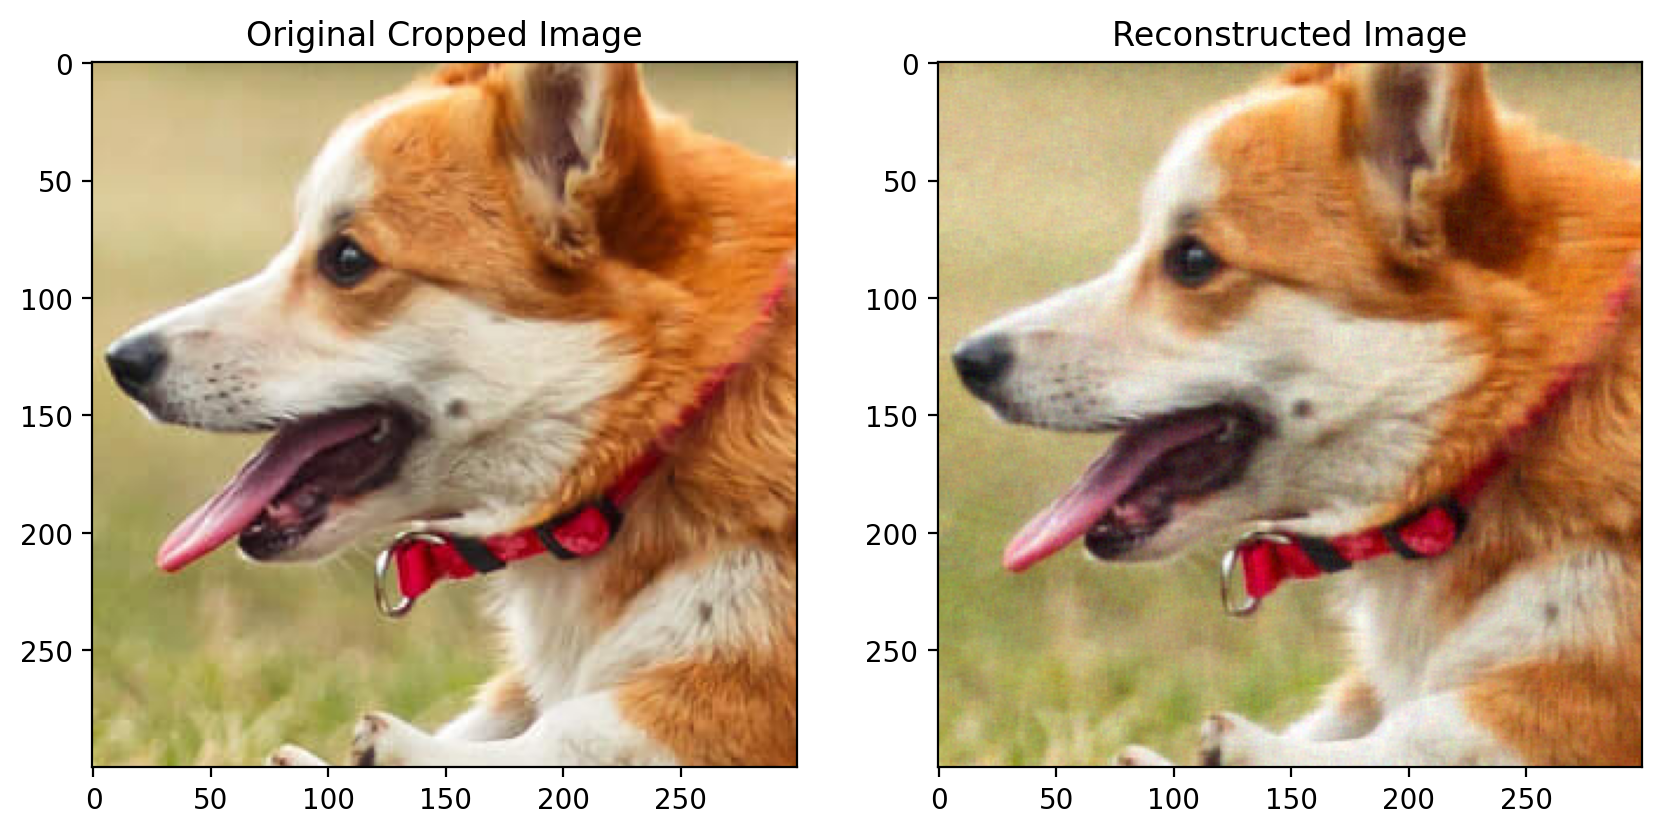

In [19]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import crop

# Define existing functions for RMSE and PSNR
def compute_rmse(original, reconstructed):
    original_np = original.numpy()
    reconstructed_np = reconstructed.numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    return np.sqrt(mse_value)

def compute_psnr(original, reconstructed, data_range=1.0):
    original_np = original.numpy()
    reconstructed_np = reconstructed.numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    if mse_value == 0:
        return float('inf')
    return 20 * np.log10(data_range / np.sqrt(mse_value))

# Load image
image_path = 'dog.jpg'
img = torchvision.io.read_image(image_path).float() / 255.0  # Load image and normalize to [0, 1]
print(f"Original image shape: {img.shape}")

# Crop the image
cropped_img = crop(img, top=600, left=800, height=300, width=300)
print(f"Cropped image shape: {cropped_img.shape}")

# Convert the cropped image to separate color channels
channels = cropped_img

# Factorize each channel and reconstruct
k = 150  # Example rank
reconstructed_channels = []

for i in range(channels.shape[0]):
    channel = channels[i, :, :]  # Each color channel is (H, W)
    W, H, _ = factorize(channel, k)  # Using your factorization function
    reconstructed_channel = torch.mm(W, H).cpu().detach()
    reconstructed_channels.append(reconstructed_channel.unsqueeze(0))

# Combine the reconstructed channels
reconstructed_img = torch.cat(reconstructed_channels, dim=0).permute(1, 2, 0).numpy()

# Compute RMSE and PSNR for each channel
rmse_total = 0
psnr_total = 0

for i in range(channels.shape[0]):
    original_channel = torch.tensor(cropped_img[i, :, :], dtype=torch.float32)
    reconstructed_channel = torch.tensor(reconstructed_img[:, :, i], dtype=torch.float32)
    rmse_value = compute_rmse(original_channel, reconstructed_channel)
    psnr_value = compute_psnr(original_channel, reconstructed_channel, data_range=1.0)
    rmse_total += rmse_value
    psnr_total += psnr_value

print(f'Average RMSE: {rmse_total / channels.shape[0]}')
print(f'Average PSNR: {psnr_total / channels.shape[0]}')

# Display original and reconstructed images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cropped_img.permute(1, 2, 0).numpy())
ax[0].set_title("Original Cropped Image")
ax[1].imshow(reconstructed_img)
ax[1].set_title("Reconstructed Image")
plt.show()


### 2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.[3 Marks]

Image Reconstruction Using Matrix Factorisation

Original image shape: torch.Size([3, 1365, 2048])
Cropped image shape: torch.Size([3, 300, 300])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average RMSE: 0.035975392907857895
Average PSNR: 29.00621593982807


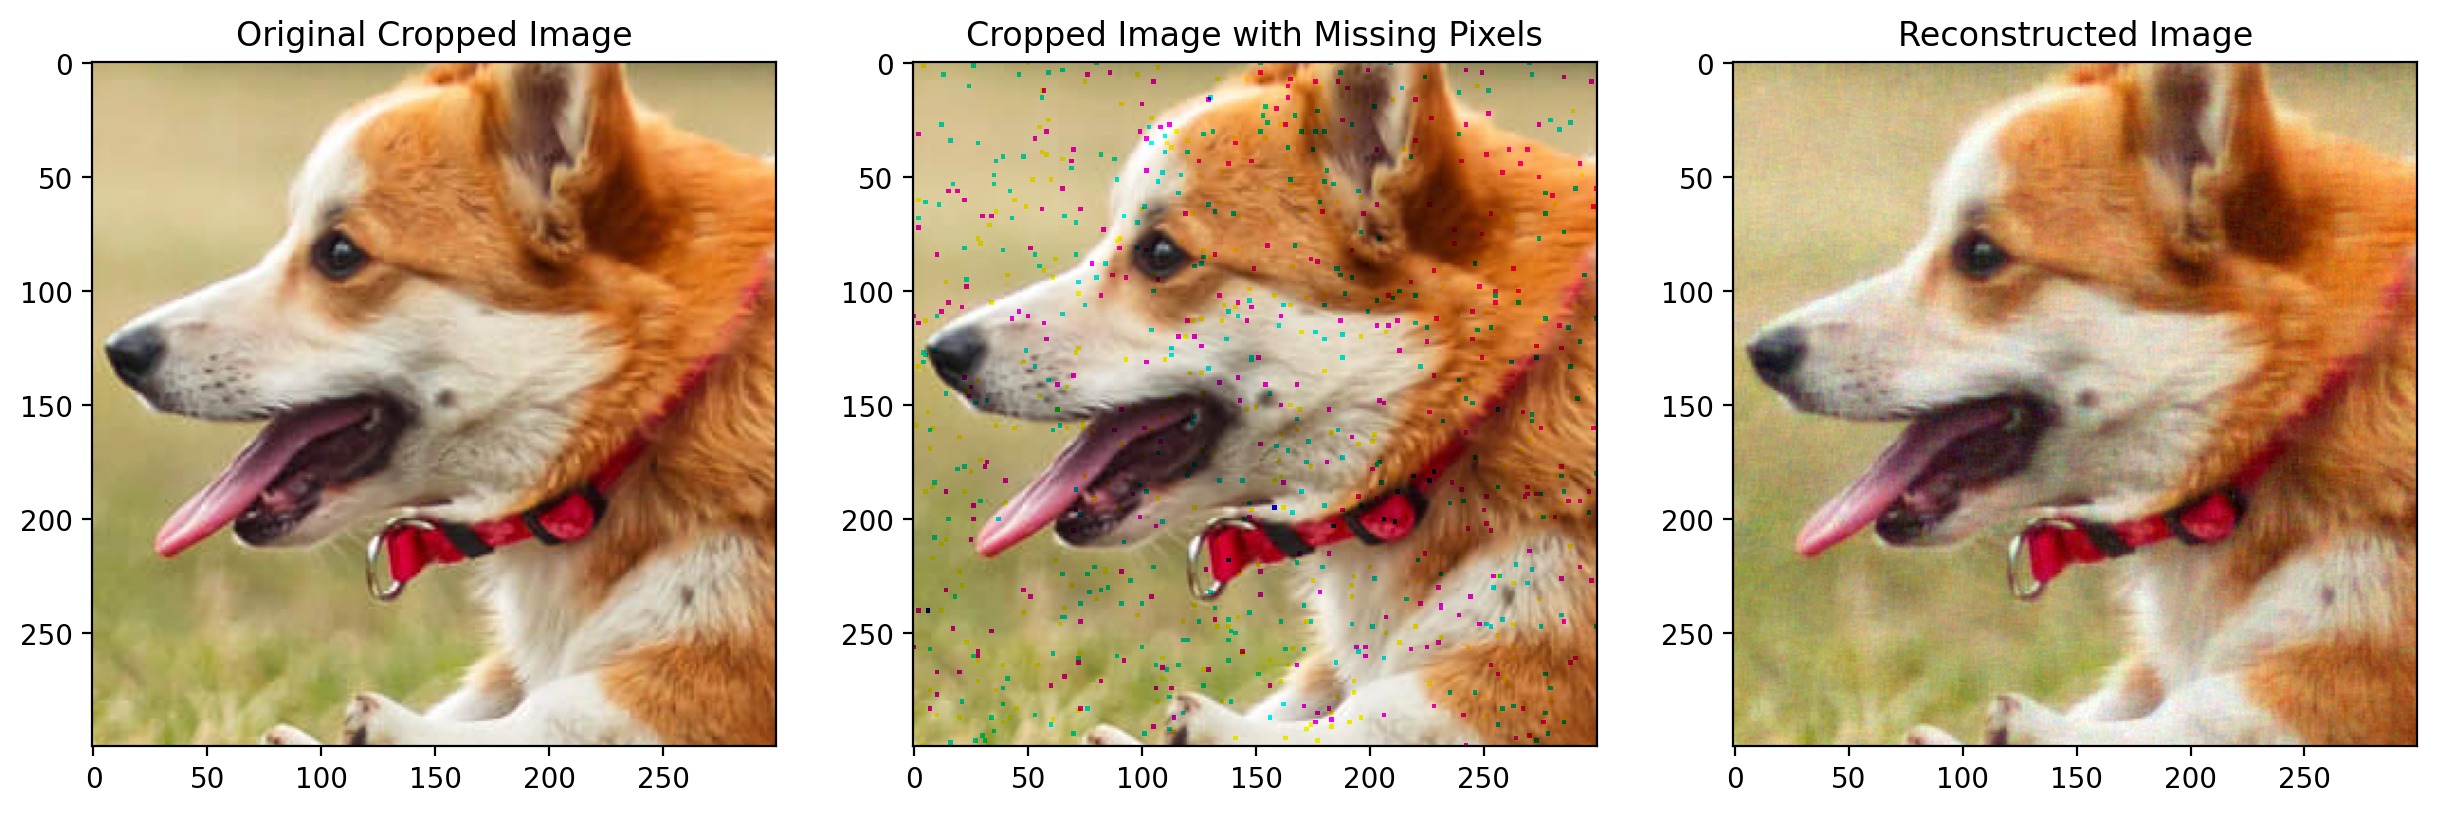

In [20]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import crop
import torch.optim as optim

# Factorization function with missing values handled
def factorize_with_missing(A, k, mask, device=torch.device("cpu"), lr=0.01, max_iters=10000, tol=1e-4):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=lr)
    
    prev_loss = float('inf')
    
    for i in range(max_iters):
        diff_matrix = torch.mm(W, H) - A
        loss = torch.norm(diff_matrix[mask])  # Only calculate loss over known pixels
        
        if abs(prev_loss - loss.item()) < tol:
            break
        prev_loss = loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return W, H, loss

# Function to compute RMSE and PSNR
def compute_rmse(original, reconstructed, mask):
    mse_value = torch.mean((original[mask] - reconstructed[mask]) ** 2)
    return torch.sqrt(mse_value).item()

def compute_psnr(original, reconstructed, mask, data_range=1.0):
    mse_value = torch.mean((original[mask] - reconstructed[mask]) ** 2)
    if mse_value == 0:
        return float('inf')
    return 20 * np.log10(data_range / torch.sqrt(mse_value).item())

# Load and process image
image_path = 'dog.jpg'
img = torchvision.io.read_image(image_path).float() / 255.0
print(f"Original image shape: {img.shape}")

# Crop the image
cropped_img = crop(img, top=600, left=800, height=300, width=300)
print(f"Cropped image shape: {cropped_img.shape}")

# Introduce missing pixels randomly (set to NaN)
n_missing = 900  # Number of pixels to randomly remove
mask = torch.ones_like(cropped_img, dtype=torch.bool)

# Randomly choose pixel positions to set as missing (NaN)
missing_indices = np.random.choice(cropped_img.numel(), n_missing, replace=False)
cropped_img_flat = cropped_img.reshape(-1)

cropped_img_flat[missing_indices] = float('nan')
mask_flat = mask.reshape(-1)
mask_flat[missing_indices] = False

# Reshape back to original shape
cropped_img_missing = cropped_img_flat.view(cropped_img.shape)
mask = mask_flat.view(mask.shape)


# Separate color channels and apply factorization
k = 170  # Rank for factorization
reconstructed_channels = []

for i in range(cropped_img_missing.shape[0]):
    channel = cropped_img_missing[i, :, :]  # Each color channel
    channel_mask = mask[i, :, :]
    
    W, H, _ = factorize_with_missing(channel, k, channel_mask)
    
    reconstructed_channel = torch.mm(W, H).cpu().detach()
    reconstructed_channels.append(reconstructed_channel.unsqueeze(0))

# Combine reconstructed channels
reconstructed_img = torch.cat(reconstructed_channels, dim=0)

# Compute RMSE and PSNR for each channel (only on non-missing pixels)
rmse_total = 0
psnr_total = 0

for i in range(cropped_img_missing.shape[0]):
    original_channel = cropped_img[i, :, :]  # Ground truth
    reconstructed_channel = reconstructed_img[i, :, :]
    channel_mask = mask[i, :, :]
    
    rmse_value = compute_rmse(original_channel, reconstructed_channel, channel_mask)
    psnr_value = compute_psnr(original_channel, reconstructed_channel, channel_mask)
    
    rmse_total += rmse_value
    psnr_total += psnr_value

print(f'Average RMSE: {rmse_total / cropped_img_missing.shape[0]}')
print(f'Average PSNR: {psnr_total / cropped_img_missing.shape[0]}')

# Display original, missing, and reconstructed images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cropped_img.permute(1, 2, 0).numpy())
ax[0].set_title("Original Cropped Image")
ax[1].imshow(cropped_img_missing.permute(1, 2, 0).numpy())
ax[1].set_title("Cropped Image with Missing Pixels")
ax[2].imshow(reconstructed_img.permute(1, 2, 0).numpy())
ax[2].set_title("Reconstructed Image")
plt.show()


Image Reconstruction Using Random Forest Features and Linear Regression

In [44]:
import torch 
import torchvision
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
import torch.nn as nn
import matplotlib.gridspec as gridspec  # Needed for the plotting

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load and process the image
image_path = 'dog.jpg'
img = torchvision.io.read_image(image_path).float() / 255.0
print(f"Original image shape: {img.shape}")

# Crop the image
cropped_img = torchvision.transforms.functional.crop(img, top=600, left=800, height=300, width=300)
print(f"Cropped image shape: {cropped_img.shape}")

# Step 2: Introduce missing pixels randomly (set to NaN)
n_missing = 900  # Number of pixels to randomly remove
mask = torch.ones_like(cropped_img, dtype=torch.bool)

# Randomly choose pixel positions to set as missing (NaN)
missing_indices = np.random.choice(cropped_img.numel(), n_missing, replace=False)
cropped_img_flat = cropped_img.flatten()
mask_flat = mask.flatten()

# Set the randomly chosen pixels to NaN and mark them as missing in the mask
cropped_img_flat[missing_indices] = float('nan')
mask_flat[missing_indices] = False

# Reshape back to original shape
cropped_img_missing = cropped_img_flat.reshape(cropped_img.shape)
mask = mask_flat.reshape(mask.shape)

# Replace NaNs with zero (or another default value) for processing
cropped_img_missing = torch.nan_to_num(cropped_img_missing, nan=0.0)

# Check for NaNs in the missing image
assert not torch.isnan(cropped_img_missing).any(), "cropped_img_missing contains NaNs after initial processing"

# Step 3: Generate Random Fourier Features (RFF)
def create_coordinate_map(img):
    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()
    Y = rearrange(img, 'c h w -> (h w) c').float()
    non_zero_mask = (Y != 0).any(dim=1)  # Valid pixels

    X_valid = X[non_zero_mask]
    Y_valid = Y[non_zero_mask]

    return X_valid.to(device), Y_valid.to(device)

def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

# Step 4: Define Linear Regression model
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    
    def forward(self, x):
        return self.linear(x)

# Step 5: Create coordinate map and RFF features for the cropped image
X, Y = create_coordinate_map(cropped_img_missing)  # Coordinate map (H, W)
D = 20000  # Number of RFF features
sigma = 0.005
X_rff = create_rff_features(X, D, sigma)

# Step 6: Train the Linear Regression model only on known pixels
net = LinearModel(X_rff.shape[1], 3).to(device)

def train(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

lr = 0.001  # Learning rate
epochs = 1000  # Number of epochs
train(net, lr, X_rff, Y, epochs, verbose=True)


Original image shape: torch.Size([3, 1365, 2048])
Cropped image shape: torch.Size([3, 300, 300])
Epoch 0 loss: 0.369159
Epoch 100 loss: 0.267884
Epoch 200 loss: 0.193412
Epoch 300 loss: 0.140035
Epoch 400 loss: 0.102873
Epoch 500 loss: 0.077716
Epoch 600 loss: 0.061124
Epoch 700 loss: 0.050446
Epoch 800 loss: 0.043732
Epoch 900 loss: 0.039598


0.03711335361003876

In [62]:
def plot_reconstructed_and_original_image(original_img, net, X_full, mask):
    net.eval()
    num_channels, height, width = original_img.shape

    mask_flat = mask[0].flatten()
    known_pixel_positions = mask_flat.nonzero().squeeze()
    missing_pixel_positions = (~mask_flat).nonzero().squeeze()

    with torch.no_grad():
        valid_missing_positions = missing_pixel_positions[missing_pixel_positions < X_full.size(0)]
        
        if len(valid_missing_positions) > 0:
            X_missing = X_full[valid_missing_positions]
    
            # Generate RFF features for X_missing
            D = 20000  # Ensure this matches the expected output features of the model
            sigma = 0.005  # Use the same sigma as before
            X_missing_rff = create_rff_features(X_missing, D, sigma)

            # Predict the missing pixel values
            predicted_values = net(X_missing_rff)

            reconstructed_img = original_img.clone()
            reconstructed_img_flat = reconstructed_img.flatten(1)
            reconstructed_img_flat[:, valid_missing_positions] = predicted_values.permute(1, 0)
            reconstructed_img = reconstructed_img_flat.reshape(original_img.shape)
        else:
            reconstructed_img = original_img

    return reconstructed_img

def plot_images(cropped_img, reconstructed_img, original_img, title=""):
    # Function to ensure image is in HWC format
    def ensure_hwc_format(img):
        if img.dim() == 3:
            if img.shape[0] == 3:  # C, H, W
                return img.permute(1, 2, 0)  # Convert to HWC
            elif img.shape[0] == 1:  # Grayscale (1, H, W)
                return img.squeeze(0).numpy()  # Convert to (H, W)
        return img.numpy() if img.dim() == 2 else img  # Ensure it's a numpy array

    # Ensure all images are in HWC format
    cropped_img = ensure_hwc_format(cropped_img)
    reconstructed_img = ensure_hwc_format(reconstructed_img)
    original_img = ensure_hwc_format(original_img)

    # Create subplots for three images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Cropped Image with Missing Pixels
    axes[0].imshow(cropped_img)
    axes[0].set_title("Cropped Image with Missing Pixels")
    axes[0].axis("off")

    # Reconstructed Image
    axes[1].imshow(reconstructed_img)
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")

    # Original Image
    axes[2].imshow(original_img)
    axes[2].set_title("Original Image")
    axes[2].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Use the functions
full_coordinates = create_coordinate_map(cropped_img)[0]
reconstructed_img = plot_reconstructed_and_original_image(cropped_img, net, full_coordinates, mask)



RMSE: 0.012336117215454578
PSNR: 38.176429748535156 dB


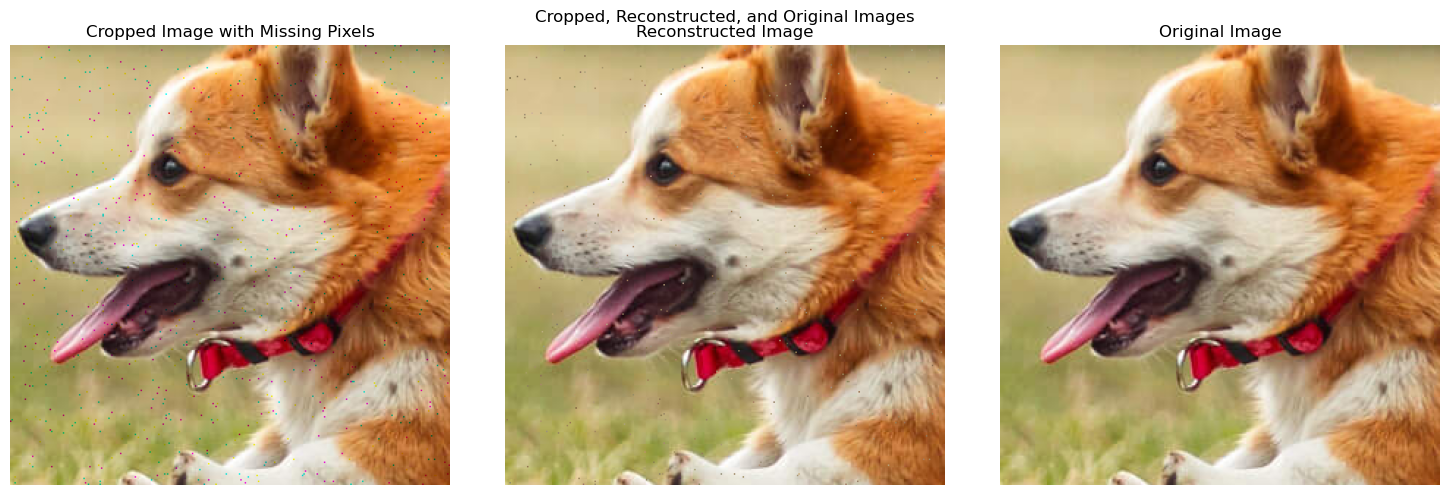

In [63]:
import torch

def compute_rmse(original, reconstructed):
    # Calculate RMSE
    return torch.sqrt(torch.mean((original - reconstructed) ** 2)).item()

def compute_psnr(original, reconstructed):
    # Ensure both images are in the same range
    original = original.float()  # Convert to float tensor if not already
    reconstructed = reconstructed.float()
    
    # Compute Mean Squared Error (MSE)
    mse = torch.mean((original - reconstructed) ** 2)
    if mse.item() == 0:
        return float('inf')  # Infinite PSNR for identical images

    max_pixel_value = 1.0 if original.max() <= 1 else 255.0  # Depending on the image scale
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

# Assuming cropped_img is the original image you want to compare with
full_coordinates = create_coordinate_map(cropped_img)[0]
reconstructed_img = plot_reconstructed_and_original_image(cropped_img, net, full_coordinates, mask)

# Compute RMSE and PSNR
rmse = compute_rmse(cropped_img, reconstructed_img)  # Use cropped_img or the appropriate original image
psnr = compute_psnr(cropped_img, reconstructed_img)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr} dB")

plot_images(cropped_img_missing, reconstructed_img, cropped_img, title="Cropped, Reconstructed, and Original Images")
